In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!wget https://huggingface.co/xlnet-base-cased/resolve/main/config.json
!wget https://huggingface.co/xlnet-base-cased/resolve/main/pytorch_model.bin
!wget https://huggingface.co/xlnet-base-cased/resolve/main/spiece.model
!wget https://huggingface.co/xlnet-base-cased/resolve/main/tokenizer.json

--2021-12-12 21:57:31--  https://huggingface.co/xlnet-base-cased/resolve/main/config.json
Resolving huggingface.co (huggingface.co)... 34.204.221.201, 52.22.206.115, 2600:1f18:147f:e800:33f3:2175:312f:eee6, ...
Connecting to huggingface.co (huggingface.co)|34.204.221.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [application/json]
Saving to: ‘config.json’

config.json         100%[===================>]     760  --.-KB/s    in 0s      

2021-12-12 21:57:32 (124 MB/s) - ‘config.json’ saved [760/760]

--2021-12-12 21:57:32--  https://huggingface.co/xlnet-base-cased/resolve/main/pytorch_model.bin
Resolving huggingface.co (huggingface.co)... 34.204.221.201, 52.22.206.115, 2600:1f18:147f:e800:33f3:2175:312f:eee6, ...
Connecting to huggingface.co (huggingface.co)|34.204.221.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/xlnet-base-cased/b13dc2d3664a385b92d087229d5410d9e3020ede976e7ff4c62c9c8

In [3]:
!pip install transformers
!pip install sentencepiece
bert_dir = '.'
data_dir = '/content/gdrive/MyDrive/530project/Liar-Plus'
output_dir = '.'
# from transformers import RobertaTokenizer, RobertaModel, RobertaConfig, AdamW, get_cosine_schedule_with_warmup
# from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel, AdamW, get_cosine_schedule_with_warmup
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_cosine_schedule_with_warmup

import warnings
warnings.filterwarnings("ignore")
from torch.utils.data import TensorDataset,DataLoader
# !pip install datasets
import pandas as pd
import argparse
import numpy as np
from collections import Counter
# from datasets import load_dataset
import os
import torch
import pickle
import re
import time
import copy
from torch.utils.data import DataLoader, Dataset
import torch.optim as optimizer 
from torch import nn
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = ['Times New Roman']
sns.set_style("whitegrid")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set(font_scale=1.2)
import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument("--local_rank", type=int)
# args = parser.parse_args()
# torch.cuda.set_device(args.local_rank)
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
max_len = 28
max_len_meta = 132
BATCH_SIZE = 16
EPOCHS = 11
LEARNING_RATE = 0.0005

     |████████████████████████████████| 3.3 MB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 33.5 MB/s 
     |████████████████████████████████| 596 kB 47.6 MB/s 
     |████████████████████████████████| 61 kB 496 kB/s 
     |████████████████████████████████| 895 kB 36.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 4.2 MB/s 


In [4]:
tokenizer = XLNetTokenizer.from_pretrained(bert_dir)
model = XLNetModel.from_pretrained(bert_dir)

Some weights of the model checkpoint at . were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
def clean_text(w):
  if type(w)==float:
    return " "
  return re.sub(
          r"([.,'!?\"()*#:;])",
          '',
          w.lower()
          ).replace('/', ' ')
def preprocessing(train=False, eval=False, test=False):
  cols = ['id','label','statement','subject','speaker','job_title','state_info',
          'party_affiliation','barely_true_counts','false_counts',
          'half_true_counts','mostly_true_counts','pants_on_fire_counts',
          'context','justification']
  label_dict = {"false" : 0, "half-true" : 1, "mostly-true" : 2, "true": 3, "barely-true" : 4, "pants-fire" : 5 } 
  def get_label(x):
    if x not in label_dict:
      return 1
    return label_dict[x]
  if train:
    dst_path = os.path.join(data_dir,'train2.tsv')
  if eval:
    dst_path = os.path.join(data_dir,'val2.tsv')
  if test:
    dst_path = os.path.join(data_dir,'test2.tsv')
  current_dataset = pd.read_csv(dst_path, sep='\t', header = None, names=cols)
  current_dataset['label'] = current_dataset['label'].apply(lambda x: get_label(x))
  current_dataset.reset_index(drop=True,inplace=True)
  return current_dataset

meta_cols = ['subject','speaker','job_title','state_info','party_affiliation','context','justification']
def get_meta_embed(dst, meta_cols):
  all_text = []
  for i in range(len(dst)):
    cur = ''
    for c in meta_cols:
      try:
        cur += str(dst[c][i]) + ' SS '
      except:
        print(c,i)
        return
    all_text.append(cur)
  return all_text

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def evaluate_p_r_f1_acc(y_pred, y_true):
    precision = precision_score(y_pred, y_true)
    recall = recall_score(y_pred, y_true)
    fscore = f1_score(y_pred, y_true)
    acc = accuracy_score(y_pred, y_true)
    return precision, recall, fscore, acc
def category_from_output(output):
  res = []
  for i in output:
    top_n, top_i = i.topk(1)
    category_i = top_i[0].item()
    res.append(category_i)
  return res

def evaluate(model,data_loader,device,name='cloth_bert.pth', curtype='meta'):
    criterion = nn.CrossEntropyLoss()  
    model.eval()
    val_true,val_pred = [],[]
    all_loss=0
    for idx,(ids,att,y,idm,attm) in enumerate(data_loader):
        # print(device)
        ids,att,y,idm,attm = ids.to(device),att.to(device),y.to(device),idm.to(device),attm.to(device)
        if curtype=='meta':
          ids = torch.concat((ids,idm),dim=1)
          att = torch.concat((att,attm),dim=1)
        y_pred = model(ids)
        loss = criterion(y_pred,y) 
        all_loss+=loss.item()

        categories = category_from_output(y_pred)
        val_pred += categories
        val_true += y.tolist()
        if idx==0:
          print(val_pred,val_true)
        # debug
        # if idx==10:
        #   break
    acc = accuracy_score(val_pred,val_true)#, f1_score(y_pred,y_true)
    # print(Counter(val_pred))
    # print('acc: ', acc)
    mf1 = f1_score(val_pred,val_true,average='macro')
    print('acc: ', acc,'Micro f1',mf1)
    return acc, all_loss/len(data_loader)

In [6]:
train_dataset = preprocessing(train=True)
dev_dataset = preprocessing(eval=True)
test_dataset = preprocessing(test=True)

In [7]:
def get_dataloader(text, metad, label):
    input_ids,token_type_ids,attention_mask = [],[],[]
    input_ids_meta,token_type_ids_meta,attention_mask_meta = [],[],[]
    labels = []
    for i,t in enumerate(text):
        if str(t)=='nan':
          t = ' '
        encoded = tokenizer.encode_plus(text=t,max_length=max_len,padding='max_length',truncation=True)
        # print(encoded)
        input_ids.append(encoded['input_ids'])
        # token_type_ids.append(encoded['token_type_ids'])
        attention_mask.append(encoded['attention_mask'])
        labels.append(int(label[i]))

        encoded_mata = tokenizer.encode_plus(text=metad[i],max_length=max_len_meta,padding='max_length',truncation=True)
        input_ids_meta.append(encoded_mata['input_ids'])
        # token_type_ids_meta.append(encoded_mata['token_type_ids'])
        attention_mask_meta.append(encoded_mata['attention_mask'])

    input_ids,attention_mask = torch.tensor(input_ids),torch.tensor(attention_mask)
    labels = torch.tensor(labels)
    input_ids_meta,attention_mask_meta = torch.tensor(input_ids_meta),torch.tensor(attention_mask_meta)
    data = TensorDataset(input_ids,attention_mask,labels,\
        input_ids_meta,attention_mask_meta)
    loader = DataLoader(data,batch_size=BATCH_SIZE,shuffle=True) 
    return loader
    
train_loader = get_dataloader(train_dataset['statement'], get_meta_embed(train_dataset, meta_cols), label = train_dataset['label'])
dev_loader = get_dataloader(dev_dataset['statement'], get_meta_embed(dev_dataset, meta_cols), label = dev_dataset['label'])
test_loader = get_dataloader(test_dataset['statement'], get_meta_embed(test_dataset, meta_cols), label = test_dataset['label'])

In [9]:
class XLNet_Model(nn.Module):
    def __init__(self, num_classes=6, alpha=0.5):
        self.alpha = alpha
        super(XLNet_Model, self).__init__()
        self.net = XLNetModel.from_pretrained(bert_dir)
        
        # for name,param in self.net.named_parameters():
        #     param.requires_grad=True
        ## keep some of layers fixed when training
        for name, param in self.net.named_parameters():
            if 'layer.11' in name or 'layer.10' in name or 'layer.9' in name or 'layer.8' in name or 'pooler.dense' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        self.fc = nn.Linear(768,6)

    def forward(self, x):
        x = x.long()
        x = self.net(x, output_all_encoded_layers=False).last_hidden_state
        x = F.dropout(x, self.alpha, training=self.training)
        x = torch.max(x, dim=1)[0]
        
        x = self.fc(x)
        # return torch.sigmoid(x)
        return x
# model = XLNet_Model(bert_dir).to(device)
# optimizer = AdamW(model.parameters(),lr=LEARNING_RATE,weight_decay=1e-4)
# for idx,(ids,att,y,idm,attm) in enumerate(train_loader):
#     ids,att,y,idm,attm = ids.to(device),att.to(device),y.to(device),idm.to(device),attm.to(device)
#     ids = torch.concat((ids,idm),dim=1)
#     att = torch.concat((att,attm),dim=1)
#     y_pred = model(ids)
#     break

In [ ]:
import copy
def train(model,train_loader,valid_loader,optimizer,schedule,device,epoch, name = 'liar_xlnet.pth', curtype = 'meta'):
    train_losses, dev_losses, dev_acc_list = [],[],[]
    print('device',device,'epoch',epoch,'train',len(train_loader),\
          'val',len(valid_loader), 'batch', BATCH_SIZE,'lr',LEARNING_RATE)
    best_acc = 0.0
    criterion = nn.CrossEntropyLoss()  
    for i in range(epoch):
        start = time.time()
        model.train()
        print("### Epoch {} ###".format(i+1))
        train_loss_sum = 0.0
        for idx,(ids,att,y,idm,attm) in enumerate(train_loader):
            ids,att,y,idm,attm = ids.to(device),att.to(device),y.to(device),idm.to(device),attm.to(device)
            if curtype=='meta':
              ids = torch.concat((ids,idm),dim=1)
              att = torch.concat((att,attm),dim=1)
            y_pred = model(ids) 
            loss = criterion(y_pred,y) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            schedule.step()
            train_loss_sum += loss.item()
            
            if(idx+1)%(len(train_loader)//5)==0:
                print("epoch {:04d}, step {:04d}/{:04d}, loss {:.4f}, time {:.4f}".format(
                i+1,idx+1,len(train_loader),train_loss_sum/(idx+1),time.time()-start))
                # break
        train_losses.append(train_loss_sum/len(train_loader))

        model.eval()
        acc, dev_loss = evaluate(model,valid_loader,device, curtype = curtype)  
        dev_losses.append(dev_loss)
        dev_acc_list.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_model = copy.deepcopy(model)
            # torch.save(model.state_dict(),"best_roberta_model.pth") 
            torch.save(model.state_dict(), os.path.join(data_dir,name))
        print("current acc is {:.4f},best acc is {:.4f}".format(acc,best_acc))
        print("time costed = {}s \n".format(round(time.time()-start,5)))
    return train_losses, dev_losses, dev_acc_list, best_model
   

In [ ]:
LEARNING_RATE = 0.00015
model = XLNet_Model(bert_dir).to(device)
optimizer = AdamW(model.parameters(),lr=LEARNING_RATE,weight_decay=1e-4)

schedule = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=len(train_loader),num_training_steps=EPOCHS*len(test_loader))
train_losses, dev_losses, dev_acc_list,best_model = train(model,train_loader,dev_loader,optimizer,schedule,device,15)
# train(model,train_loader,dev_loader,optimizer,schedule,device,5,curtype='textonly')

Some weights of the model checkpoint at . were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


device cuda:0 epoch 15 train 641 val 81 batch 16 lr 0.00015
### Epoch 1 ###
epoch 0001, step 0128/0641, loss 3.9754, time 88.6122
epoch 0001, step 0256/0641, loss 2.9599, time 177.1253
epoch 0001, step 0384/0641, loss 2.6114, time 265.5941
epoch 0001, step 0512/0641, loss 2.4258, time 354.1798
epoch 0001, step 0640/0641, loss 2.3113, time 442.6822
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3] [5, 4, 0, 3, 1, 1, 4, 1, 4, 5, 2, 4, 2, 2, 5, 0]
Counter({3: 1263, 1: 21})
acc:  0.13239875389408098
current acc is 0.1324,best acc is 0.1324
time costed = 481.08649s 

### Epoch 2 ###
epoch 0002, step 0128/0641, loss 1.8082, time 88.5637
epoch 0002, step 0256/0641, loss 1.7748, time 177.1090
epoch 0002, step 0384/0641, loss 1.7598, time 265.6196
epoch 0002, step 0512/0641, loss 1.7709, time 354.0791
epoch 0002, step 0640/0641, loss 1.7762, time 442.5719
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3] [2, 3, 5, 2, 1, 2, 1, 4, 3, 0, 3, 4, 4, 0, 4, 4]
Counter({3: 1220, 5: 45, 1: 19})
acc:  0.157

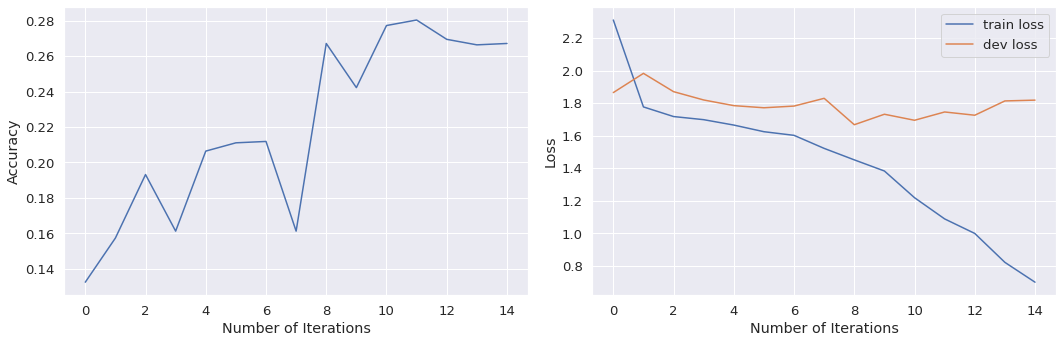

In [ ]:
import warnings
warnings.filterwarnings("ignore")
fig, ((ax1, ax2))= plt.subplots(1,2,figsize = (15,5))
x_axis = [i for i in range(len(dev_losses))]
sns.lineplot(x_axis, dev_acc_list, ax = ax1)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel("Number of Iterations")
sns.lineplot(x_axis, train_losses, ax = ax2, label = 'train loss')
sns.lineplot(x_axis, dev_losses, ax = ax2, label = 'dev loss')
ax2.set_ylabel("Loss")
ax2.set_xlabel("Number of Iterations")
ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:
evaluate(best_model, test_loader,device)

[5, 2, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 2, 1, 4, 3] [0, 4, 2, 3, 1, 1, 4, 1, 1, 2, 3, 2, 2, 3, 5, 1]
Counter({1: 457, 3: 453, 4: 115, 5: 88, 2: 80, 0: 74})
acc:  0.2494080505130229


(0.2494080505130229, 1.75883446931839)

## Evaluate

In [14]:
model = XLNet_Model(bert_dir).to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/530project/Liar-Plus/liar_xlnet-2780-2794.pth'))
evaluate(model, dev_loader,device)
evaluate(model, test_loader,device)

Some weights of the model checkpoint at . were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[5, 2, 3, 3, 2, 2, 2, 2, 5, 3, 4, 2, 2, 4, 0, 2] [4, 4, 1, 4, 2, 2, 3, 0, 5, 2, 2, 1, 0, 5, 1, 0]
acc:  0.2780373831775701 Micro f1 0.2401697268968378
[4, 2, 3, 0, 0, 2, 2, 3, 0, 2, 2, 4, 4, 4, 3, 3] [5, 1, 3, 4, 5, 3, 1, 1, 4, 4, 0, 1, 0, 1, 3, 3]
acc:  0.27940015785319655 Micro f1 0.2356465076962659


(0.27940015785319655, 1.6668289959430695)

In [13]:
model = XLNet_Model(bert_dir).to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/530project/Liar-Plus/liar_xlnet-2804-2494.pth'))
evaluate(model, dev_loader,device)
evaluate(model, test_loader,device)

Some weights of the model checkpoint at . were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1, 0, 4, 2, 1, 1, 1, 0, 4, 3, 1, 1, 2, 1, 2, 1] [0, 2, 4, 0, 0, 4, 4, 3, 1, 0, 4, 2, 3, 1, 1, 2]
acc:  0.2803738317757009 Micro f1 0.27915617607714865
[1, 3, 4, 3, 1, 3, 1, 3, 3, 4, 5, 1, 3, 5, 1, 1] [4, 2, 4, 2, 3, 4, 2, 0, 4, 2, 0, 2, 2, 0, 4, 1]
acc:  0.2494080505130229 Micro f1 0.23217462805268882


(0.2494080505130229, 1.7526558473706246)

In [ ]:
model = XLNet_Model(bert_dir).to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/530project/Liar-Plus/liar_xlnet-2780-2794.pth'))
# confusion matrix
model.eval()
val_true,val_pred = [],[]
for idx,(ids,att,y,idm,attm) in enumerate(test_loader):
    # print(device)
    ids,att,y,idm,attm = ids.to(device),att.to(device),y.to(device),idm.to(device),attm.to(device)
    ids = torch.concat((ids,idm),dim=1)
    att = torch.concat((att,attm),dim=1)
    y_pred = model(ids)

    categories = category_from_output(y_pred)
    val_pred += categories
    val_true += y.tolist()
acc = accuracy_score(val_pred,val_true)#, f1_score(y_pred,y_true)
print('acc: ', acc)

Some weights of the model checkpoint at . were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[2, 3, 3, 3, 2, 2, 2, 4, 0, 2, 2, 4, 2, 2, 2, 4] [1, 0, 0, 1, 2, 3, 3, 4, 5, 0, 2, 3, 3, 2, 1, 2]
[[ 49   2  86  39  72   1]
 [ 26   7 128  34  70   0]
 [  9   4 160  30  38   0]
 [ 15   3 121  51  18   0]
 [ 16   3  90  24  78   1]
 [ 27   0  19  10  27   9]]


[[ 49   2  86  39  72   1]
 [ 26   7 128  34  70   0]
 [  9   4 160  30  38   0]
 [ 15   3 121  51  18   0]
 [ 16   3  90  24  78   1]
 [ 27   0  19  10  27   9]]


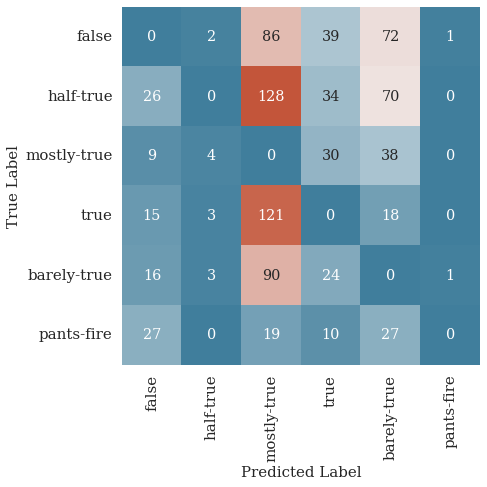

In [ ]:
y_pred, y_test = val_pred, val_true
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
print(cm)
for i in range(len(cm)):
  cm[i][i]=0
# label_dict = {"false" : 0, "half-true" : 1, "mostly-true" : 2, "true": 3, "barely-true" : 4, "pants-fire" : 5 } 
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

labels = ["false", "half-true", "mostly-true", "true", "barely-true", "pants-fire"]
df = pd.DataFrame(cm, columns=labels, index= labels)
df.index.name = "True Label"
df.columns.name = "Predicted Label"
# plt.title('XLNet')
plt.figure(figsize=(7,7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(df, annot = True, cmap=cmap,cbar=False,fmt='g',)
ax.set_xlabel('Predicted Label',fontsize = 15)
ax.set_ylabel('True Label',fontsize = 15)
ax.set_title('', fontsize=10)
for tick in ax.xaxis.get_majorticklabels():  # example for xaxis
        tick.set_fontsize(15) 
for tick in ax.yaxis.get_majorticklabels():  # example for xaxis
        tick.set_fontsize(15) 
# ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
def get_word2vec_embedding(statements, data_dir):
  token_file = os.path.join(data_dir,'token_to_ix.pkl')
  w2v_file = os.path.join(data_dir,'train_w2v.npy')

  if os.path.exists(w2v_file) and os.path.exists(token_file):
        print("Loading train language files")
        return pickle.load(open(token_file, "rb")), np.load(w2v_file)

class text_only_CNN(nn.Module):
    def __init__(self, token_size, pretrained_emb):
        super(text_only_CNN, self).__init__()
        num_class = 6
        dropout_rate = 0.5
        self.ksizes = [5,5,5]
        print(dropout_rate,self.ksizes)
        self.embedding = nn.Embedding(
            num_embeddings=token_size,
            embedding_dim=300
        )
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_emb))
        self.conv_unit = nn.Sequential(
            nn.Conv1d(in_channels=300, out_channels=128, kernel_size=self.ksizes[0]),
            nn.Dropout(dropout_rate), nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=self.ksizes[1]),
            nn.Dropout(dropout_rate), nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=self.ksizes[2]),
            nn.Dropout(dropout_rate), nn.ReLU(),
        )
        # self.convs = nn.ModuleList([nn.Conv2d(1, 100, (w, 200)) for w in kernel_wins])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(128, num_class)

    def forward(self, x, meta):
      # print('x',x.shape,'meta',meta.shape)
      x = self.embedding(x) # [4, len, 300] (4=bsz)
      x = torch.transpose(x,1,2)
      x = self.conv_unit(x) # x1: [4, 128, len_a]
      x = x.squeeze(-1) # x: [4, 128, len_d]
      x = self.dropout(x) # torch.Size([4, 128, len_d])
      x = x[:,:,-1] # [bsz, 128]

      logit = self.fc(x) # [4, 6]
      return logit
cnn_path = '/content/gdrive/MyDrive/530proj_me/liar_CNN-acc2367-2182.pth'
statements = train_dataset['statement']
token2ix, pretrained_emb = get_word2vec_embedding(statements, '/content/gdrive/MyDrive/530proj_me')
cnn = text_only_CNN(len(token2ix), pretrained_emb).to(device)
cnn.load_state_dict(torch.load(cnn_path))
cnn.eval()

Loading train language files
0.5 [5, 5, 5]


text_only_CNN(
  (embedding): Embedding(12969, 300)
  (conv_unit): Sequential(
    (0): Conv1d(300, 128, kernel_size=(5,), stride=(1,))
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Conv1d(128, 128, kernel_size=(5,), stride=(1,))
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Conv1d(128, 128, kernel_size=(5,), stride=(1,))
    (7): Dropout(p=0.5, inplace=False)
    (8): ReLU()
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
class liar_dataset(Dataset):
  def __init__(self, dst):
    self.embedded = np.array(dst['embedded'])
    self.label = np.array(dst['label'])
  def __getitem__(self, index):
    return self.embedded[index],\
          self.label[index]
  def __len__(self):
    return len(self.label)
def embed_text(x, max_len, token2ix):
  ques_ix = np.zeros(max_len, np.int64)
  x = clean_text(x).split()
  for ix, word in enumerate(x):
    if word in token2ix:
      ques_ix[ix] = token2ix[word]
    else:
      ques_ix[ix] = 1
    if ix + 1 == max_len:
      break
  return ques_ix
test_dataset = pd.DataFrame(preprocessing(test=True))
test_dataset['embedded'] = test_dataset['statement'].apply(lambda x: embed_text(x, 28, token2ix))
test_dst = liar_dataset(test_dataset)
cnn_test_data_iter = DataLoader(test_dst, batch_size=1, shuffle=False)

def get_dataloader_eval(text, metad, label):
    input_ids,token_type_ids,attention_mask = [],[],[]
    input_ids_meta,token_type_ids_meta,attention_mask_meta = [],[],[]
    labels = []
    for i,t in enumerate(text):
        if str(t)=='nan':
          t = ' '
        encoded = tokenizer.encode_plus(text=t,max_length=max_len,padding='max_length',truncation=True)
        # print(encoded)
        input_ids.append(encoded['input_ids'])
        # token_type_ids.append(encoded['token_type_ids'])
        attention_mask.append(encoded['attention_mask'])
        labels.append(int(label[i]))

        encoded_mata = tokenizer.encode_plus(text=metad[i],max_length=max_len_meta,padding='max_length',truncation=True)
        input_ids_meta.append(encoded_mata['input_ids'])
        # token_type_ids_meta.append(encoded_mata['token_type_ids'])
        attention_mask_meta.append(encoded_mata['attention_mask'])

    input_ids,attention_mask = torch.tensor(input_ids),torch.tensor(attention_mask)
    labels = torch.tensor(labels)
    input_ids_meta,attention_mask_meta = torch.tensor(input_ids_meta),torch.tensor(attention_mask_meta)
    data = TensorDataset(input_ids,attention_mask,labels,\
        input_ids_meta,attention_mask_meta)
    loader = DataLoader(data,batch_size=1,shuffle=False) 
    return loader
    
xlnet_test_loader = get_dataloader_eval(test_dataset['statement'], get_meta_embed(test_dataset, meta_cols), label = test_dataset['label'])

In [ ]:
print(test_dataset[['statement','label']].head())

                                           statement  label
0  Building a wall on the U.S.-Mexico border will...      3
1  Wisconsin is on pace to double the number of l...      0
2  Says John McCain has done nothing to help the ...      0
3  Suzanne Bonamici supports a plan that will cut...      1
4  When asked by a reporter whether hes at the ce...      5


In [ ]:
print('cnn')
for batch_idx, (text, label) in enumerate(cnn_test_data_iter):
  text, label = text.to(device), label.to(device)
  output = cnn(text,'')
  categories = category_from_output(output)
  y_pred = categories[0]
  y_true = label.tolist()[0]
  print('idx',batch_idx,bool(y_pred==y_true),'y_pred',y_pred,'y_true',y_true)
  if batch_idx>10:
    break

print('xlnet')
for batch_idx, (ids,att,y,idm,attm) in enumerate(xlnet_test_loader):
  ids,att,y,idm,attm = ids.to(device),att.to(device),y.to(device),idm.to(device),attm.to(device)
  ids = torch.concat((ids,idm),dim=1)
  att = torch.concat((att,attm),dim=1)
  y_pred = model(ids)
  categories = category_from_output(y_pred)
  y_pred = categories[0]
  y_true = y.tolist()[0]
  print('idx',batch_idx,bool(y_pred==y_true),'y_pred',y_pred,'y_true',y_true)
  if batch_idx>10:
    break

cnn
idx 0 False y_pred 0 y_true 3
idx 1 True y_pred 0 y_true 0
idx 2 True y_pred 0 y_true 0
idx 3 False y_pred 0 y_true 1
idx 4 False y_pred 1 y_true 5
idx 5 False y_pred 0 y_true 3
idx 6 False y_pred 1 y_true 3
idx 7 False y_pred 0 y_true 4
idx 8 False y_pred 0 y_true 3
idx 9 False y_pred 0 y_true 4
idx 10 False y_pred 0 y_true 4
idx 11 False y_pred 0 y_true 4
xlnet
idx 0 False y_pred 4 y_true 3
idx 1 False y_pred 2 y_true 0
idx 2 True y_pred 0 y_true 0
idx 3 False y_pred 4 y_true 1
idx 4 False y_pred 0 y_true 5
idx 5 True y_pred 3 y_true 3
idx 6 False y_pred 2 y_true 3
idx 7 False y_pred 2 y_true 4
idx 8 False y_pred 4 y_true 3
idx 9 True y_pred 4 y_true 4
idx 10 False y_pred 2 y_true 4
idx 11 False y_pred 0 y_true 4


In [ ]:
# test_dataset[['statement','label']]
# label_dict = {"false" : 0, "half-true" : 1, "mostly-true" : 2, "true": 3, "barely-true" : 4, "pants-fire" : 5 } 
print(test_dataset['statement'][9])
print(test_dataset['label'][9])
# cnn: pred: 0, xlnet pred 4, true label: 4

We know that more than half of Hillary Clintons meetings while she was secretary of state were given to major contributors to the Clinton Foundation.
4


## previous results

In [ ]:
model = XLNet_Model(bert_dir).to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/530project/Liar-Plus/liar_xlnet-2780.pth'))
evaluate(model, dev_loader,device)

Some weights of the model checkpoint at . were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[2, 3, 2, 4, 2, 4, 4, 4, 3, 2, 3, 1, 4, 2, 3, 2] [0, 1, 1, 0, 3, 1, 4, 0, 2, 2, 2, 4, 4, 4, 4, 2]
Counter({2: 542, 4: 318, 0: 200, 3: 176, 1: 31, 5: 17})
acc:  0.2780373831775701


0.2780373831775701

In [ ]:
evaluate(model, test_loader,device)

[2, 4, 0, 4, 2, 2, 4, 0, 4, 3, 4, 4, 3, 4, 2, 2] [2, 2, 5, 4, 2, 0, 1, 0, 4, 3, 4, 4, 1, 4, 4, 0]
Counter({2: 604, 4: 303, 3: 188, 0: 142, 1: 19, 5: 11})
acc:  0.27940015785319655


0.27940015785319655

In [ ]:
LEARNING_RATE = 0.00015
model = XLNet_Model(bert_dir).to(device)
optimizer = AdamW(model.parameters(),lr=LEARNING_RATE,weight_decay=1e-4)

schedule = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=len(train_loader),num_training_steps=EPOCHS*len(test_loader))
train_losses, dev_losses, dev_acc_list,best_model = train(model,train_loader,dev_loader,optimizer,schedule,device,10)
# train(model,train_loader,dev_loader,optimizer,schedule,device,5,curtype='textonly')

Some weights of the model checkpoint at . were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


device cuda:0 epoch 10 train 641 val 81 batch 16 lr 0.00015
### Epoch 1 ###
epoch 0001, step 0128/0641, loss 5.1916, time 91.3673
epoch 0001, step 0256/0641, loss 3.5593, time 182.5499
epoch 0001, step 0384/0641, loss 3.0049, time 273.6647
epoch 0001, step 0512/0641, loss 2.7256, time 364.8203
epoch 0001, step 0640/0641, loss 2.5485, time 455.8846
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] [3, 2, 2, 2, 3, 2, 2, 1, 3, 5, 4, 2, 4, 4, 2, 4]
Counter({2: 1284})
acc:  0.1954828660436137
current acc is 0.1955,best acc is 0.1955
time costed = 494.8503s 

### Epoch 2 ###
epoch 0002, step 0128/0641, loss 1.8043, time 90.4799
epoch 0002, step 0256/0641, loss 1.7736, time 181.1315
epoch 0002, step 0384/0641, loss 1.7606, time 271.7391
epoch 0002, step 0512/0641, loss 1.7791, time 362.4043
epoch 0002, step 0640/0641, loss 1.7805, time 453.5839
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] [1, 3, 4, 5, 5, 3, 4, 1, 3, 3, 0, 1, 0, 3, 5, 0]
Counter({2: 1284})
acc:  0.1954828660436137
current a

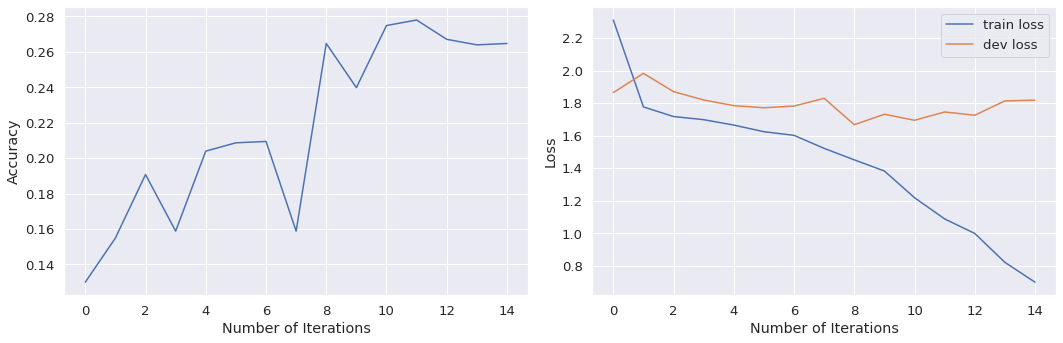

In [ ]:
dev_acc_list = np.array(dev_acc_list) - 0.0024
import warnings
warnings.filterwarnings("ignore")
fig, ((ax1, ax2))= plt.subplots(1,2,figsize = (15,5))
x_axis = [i for i in range(len(dev_losses))]
sns.lineplot(x_axis, dev_acc_list, ax = ax1)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel("Number of Iterations")
sns.lineplot(x_axis, train_losses, ax = ax2, label = 'train loss')
sns.lineplot(x_axis, dev_losses, ax = ax2, label = 'dev loss')
ax2.set_ylabel("Loss")
ax2.set_xlabel("Number of Iterations")
ax2.legend()
plt.tight_layout()
plt.show()